In [1]:
import sys

sys.path.append('../utils')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.sparse import csr_array
from typing import Union, Optional
from typing import Union, List
from utils import check_index, adjacencyplot
from os.path import join as pjoin
import itertools
import scipy.spatial as spatial
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [3]:
# UTILS
def filter_synapse_table(synapse_table: pd.DataFrame,
                         pre_root_ids=None,
                         post_root_ids=None):
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """

    if pre_root_ids is not None:
        assert isinstance(
            pre_root_ids, (np.ndarray, list, pd.core.series.Series)
        ), (f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
           )
        pre_mask = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_mask = np.ones(len(synapse_table), dtype=bool)

    if post_root_ids is not None:
        assert isinstance(
            post_root_ids, (np.ndarray, list, pd.core.series.Series)
        ), (f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
           )
        post_mask = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_mask = np.ones(len(synapse_table), dtype=bool)

    return synapse_table[pre_mask & post_mask]


In [4]:
data_dir = '/Users/rodrigo.gonzalezlaiz/Desktop/v1dd_1196'
mat_version = '1196'

In [5]:
# Loads cells with axon and dendrite proofreading
dendrite_proof_root_ids = np.load(
    pjoin(data_dir, f"proofread_dendrite_list_{mat_version}.npy"))
axon_proof_root_ids = np.load(
    pjoin(data_dir, f"proofread_axon_list_{mat_version}.npy"))

# get the ids of all proofread cells with both axon and dendrite proofreading
proof_root_ids = axon_proof_root_ids[np.isin(axon_proof_root_ids,
                                             dendrite_proof_root_ids)]

print(
    f"There are {len(dendrite_proof_root_ids)} cells with acceptable dendrites, and {len(axon_proof_root_ids)} cells with axon proofreading"
)
print(
    f"The number of cells with usable axons and dendrites is: {len(proof_root_ids)}"
)


There are 63986 cells with acceptable dendrites, and 1210 cells with axon proofreading
The number of cells with usable axons and dendrites is: 1148


In [6]:
cell_df = pd.read_feather(
    f"{data_dir}/soma_and_cell_type_{mat_version}.feather")
cell_df[[col for col in cell_df.columns if "position" in col]] /= 1000.

In [7]:
# note (rodrigo): in the workshop they only use the axon proofread cells (1164 cells)
cell_df_proofread = cell_df[
    np.isin(cell_df['pt_root_id'], axon_proof_root_ids) &
    np.isin(cell_df['pt_root_id'], dendrite_proof_root_ids)].reset_index(
        drop=True)

cell_axon_proofread_df = cell_df[np.isin(cell_df['pt_root_id'],
                                         axon_proof_root_ids)]

cell_dendrite_proofread_df = cell_df[np.isin(cell_df['pt_root_id'],
                                             dendrite_proof_root_ids)]
# cell_df_proofread_l3 = cell_df_proofread[cell_df_proofread["cell_type"] ==
#                                          "L3-IT"]

In [8]:
#NOTE(Rodrigo): proof_root_ids contains both "presynaptic" and "postsynaptic" root ids.
# only use synapses with proofread cells

syn_df = pd.read_feather(
    f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")

dendrite_proofread_syn_df = pd.read_feather(
    f"{data_dir}/syn_df_dendrite_and_coregistered_{mat_version}.feather")

# # every synapse with axon proofread cells
# axon_proofread_syn_df = filter_synapse_table(
#     syn_df,
#     pre_root_ids=axon_proof_root_ids,
#     post_root_ids=None,
# ).reset_index(drop=True)

# dendrite_proofread_syn_df = filter_synapse_table(
#     syn_df,
#     pre_root_ids=None,
#     post_root_ids=dendrite_proof_root_ids,
# ).reset_index(drop=True)

# print(syn_df.shape, axon_proofread_syn_df.shape,
#       dendrite_proofread_syn_df.shape)

In [10]:
coregistered_info = pd.read_feather(f"{data_dir}/coregistration_1196.feather")

## Simulate having random cells defined as choroist and soloist cells

In [11]:
choroist_vs_soloists_df = pd.read_csv(
    '/Users/rodrigo.gonzalezlaiz/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/projects/funcky_ensembles/Functional_Connectivity_V1DD/metadata/volume3_cell_class.csv'
)
choroist_vs_soloists_df.head()

,plane_ids,roi_ids,cell_class,p_coupling_value,stimulus
0,0,0,NaN,0.306639,p_coupling_drifting_gratings_full
1,0,1,NaN,0.271785,p_coupling_drifting_gratings_full
2,0,2,NaN,0.236877,p_coupling_drifting_gratings_full
3,0,3,NaN,0.301677,p_coupling_drifting_gratings_full
4,0,4,NaN,0.271427,p_coupling_drifting_gratings_full


In [12]:
choroist_vs_soloists_df.rename(columns={
    'plane_ids': 'plane',
    'roi_ids': 'roi'
},
                               inplace=True)

coregistered_info_with_coupling = coregistered_info.merge(
    choroist_vs_soloists_df, on=['plane', 'roi'], how='left')


In [13]:
coregistered_info_with_coupling.head()

,pt_root_id,column,volume,plane,roi,cell_class,p_coupling_value,stimulus
0,864691132830842994,1,3,0,143,NaN,0.316052,p_coupling_drifting_gratings_full
1,864691132830842994,1,3,0,143,NaN,0.233745,p_coupling_natural_movies
2,864691132830842994,1,3,0,143,NaN,0.186731,p_coupling_spontaneous
3,864691132741466457,1,3,2,40,0.0,0.400901,p_coupling_drifting_gratings_full
4,864691132741466457,1,3,2,40,1.0,0.153545,p_coupling_natural_movies


In [14]:
dendrite_proofread_syn_df.shape

(2017256, 13)

In [15]:
inputs_and_synapses_per_cell_coregistered = dendrite_proofread_syn_df.groupby(
    'post_pt_root_id').agg({
        'pre_pt_root_id': 'nunique',
        'post_pt_root_id': 'size',
        'size': 'sum'
    }).rename(
        columns={
            'pre_pt_root_id': 'inputs_per_cell',
            'post_pt_root_id': 'synapses_per_cell',
            'size': 'synapse_strength_per_cell'
        }).reset_index()

In [16]:
print(
    f"Mean - Inputs per cell: {inputs_and_synapses_per_cell_coregistered['inputs_per_cell'].mean():.2f}, "
    f"Synapses per cell: {inputs_and_synapses_per_cell_coregistered['synapses_per_cell'].mean():.2f}, "
    f"Synapse strength per cell: {inputs_and_synapses_per_cell_coregistered['synapse_strength_per_cell'].mean():.2f}"
)

print(
    f"Median - Inputs per cell: {inputs_and_synapses_per_cell_coregistered['inputs_per_cell'].median():.2f}, "
    f"Synapses per cell: {inputs_and_synapses_per_cell_coregistered['synapses_per_cell'].median():.2f}, "
    f"Synapse strength per cell: {inputs_and_synapses_per_cell_coregistered['synapse_strength_per_cell'].median():.2f}",
)
print(
    f"Max - Inputs per cell: {inputs_and_synapses_per_cell_coregistered['inputs_per_cell'].max()}, "
    f"Synapses per cell: {inputs_and_synapses_per_cell_coregistered['synapses_per_cell'].max()}, "
    f"Synapse strength per cell: {inputs_and_synapses_per_cell_coregistered['synapse_strength_per_cell'].max():.2f}"
)
print(
    f"Min - Inputs per cell: {inputs_and_synapses_per_cell_coregistered['inputs_per_cell'].min()}, "
    f"Synapses per cell: {inputs_and_synapses_per_cell_coregistered['synapses_per_cell'].min()}, "
    f"Synapse strength per cell: {inputs_and_synapses_per_cell_coregistered['synapse_strength_per_cell'].min():.2f}"
)

Mean - Inputs per cell: 3515.71, Synapses per cell: 3901.85, Synapse strength per cell: 6640500.37
Median - Inputs per cell: 2768.00, Synapses per cell: 2977.00, Synapse strength per cell: 5060279.00
Max - Inputs per cell: 12465, Synapses per cell: 14349, Synapse strength per cell: 25798068.00
Min - Inputs per cell: 433, Synapses per cell: 454, Synapse strength per cell: 431567.00


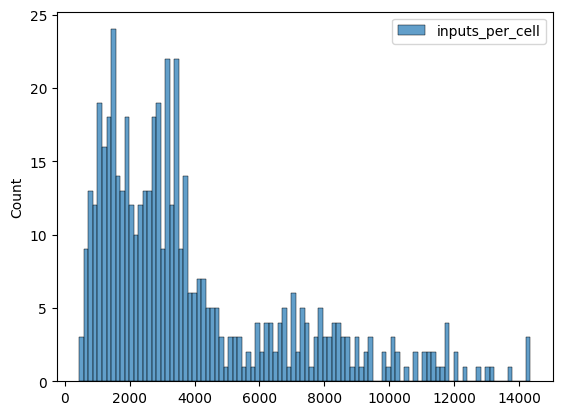

In [22]:
x = inputs_and_synapses_per_cell_coregistered['inputs_per_cell'].values
#y = inputs_and_synapses_per_cell_coregistered['synapses_per_cell'].values
sns.histplot(y, bins=100, alpha=0.7, label='inputs_per_cell')
#sns.histplot(y, bins=1000, alpha=0.7, label='synapses_per_cell')
#plt.xlim(0, 1000)
plt.legend()
plt.show()

In [21]:
# syn_label_path = (
#     f"{data_dir}/syn_label_df_all_to_proofread_to_all_{mat_version}.feather")
# syn_label_df = pd.read_feather(syn_label_path)
# syn_label_df.head()


/var/folders/zh/r3ys8n591255r84b26zk70640000gn/T/ipykernel_49749/200431787.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


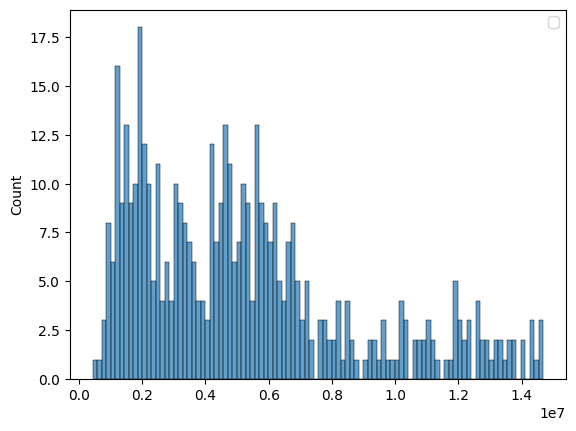

In [24]:
x = inputs_and_synapses_per_cell_coregistered[
    'synapse_strength_per_cell'].values

# Sample only the top 95th percentile to focus on high synapse strength cells
percentile_threshold = np.percentile(x, 90)
x = x[x <= percentile_threshold]

sns.histplot(x, bins=100, alpha=0.7)
#plt.xlim(0, 200)
plt.legend()
plt.show()


In [25]:
coregisterd_with_coupling_and_inputs_per_cell = coregistered_info_with_coupling.merge(
    inputs_and_synapses_per_cell_coregistered,
    left_on='pt_root_id',
    right_on='post_pt_root_id',
    how='left')

## logistic regression modeling 

In [58]:
df = coregisterd_with_coupling_and_inputs_per_cell.copy()

In [59]:
df['stimulus'].value_counts()

stimulus
p_coupling_drifting_gratings_full    560
p_coupling_natural_movies            560
p_coupling_spontaneous               560
Name: count, dtype: int64

In [67]:
stimulus = 'p_coupling_spontaneous'
#stimulus = 'p_coupling_drifting_gratings_full'
#stimulus = 'p_coupling_natural_movies'

#x_variable = 'synapse_strength_per_cell'
x_variable = 'inputs_per_cell'
df_stimulus = df[df['stimulus'] == stimulus]

# df_stimulus_choroist = df_stimulus[df_stimulus['cell_class'] == 0.0]
# df_stimulus_soloist = df_stimulus[df_stimulus['cell_class'] == 1.0]

In [68]:
# they gave only synapses with proofread axons

# but we want to use synapses with proofread dendrites.


In [69]:
# Remove rows with NaN values in inputs_per_cell
df_stimulus = df_stimulus.dropna(subset=[x_variable])
df_stimulus_choroist = df_stimulus[df_stimulus['cell_class'] == 0.0]
df_stimulus_soloist = df_stimulus[df_stimulus['cell_class'] == 1.0]

print(f"After removing NaN values in inputs_per_cell:")
print(f"Total rows: {len(df_stimulus)}")
print(f"Choroist rows: {len(df_stimulus_choroist)}")
print(f"Soloist rows: {len(df_stimulus_soloist)}")
# Take first 30% of data based on row count, not value percentile

# Sort by x_variable and take the smallest 30%
# df_stimulus = df_stimulus.sort_values(x_variable)
# n_rows_to_keep = int(len(df_stimulus) * 1)
# df_stimulus = df_stimulus.head(n_rows_to_keep)

# print(f"After removing rows with inputs_per_cell > {percentile_threshold}:")
# print(f"Choroist rows: {len(df_stimulus_choroist)}")
# print(f"Soloist rows: {len(df_stimulus_soloist)}")


After removing NaN values in inputs_per_cell:
Total rows: 523
Choroist rows: 113
Soloist rows: 59


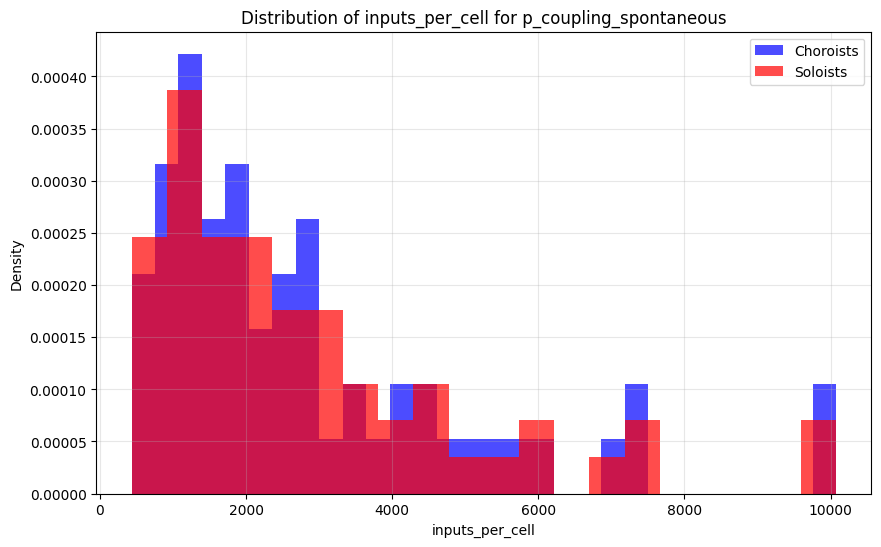

In [70]:
y_soloist = df_stimulus_soloist['p_coupling_value'].values
X_soloist = df_stimulus_soloist[x_variable].values

y_choroist = df_stimulus_choroist['p_coupling_value'].values
X_choroist = df_stimulus_choroist[x_variable].values

plt.figure(figsize=(10, 6))
plt.hist(X_soloist,
         bins=30,
         alpha=0.7,
         label='Choroists',
         color='blue',
         density=True)
plt.hist(X_soloist,
         bins=20,
         alpha=0.7,
         label='Soloists',
         color='red',
         density=True)
plt.xlabel(x_variable)
plt.ylabel('Density')
plt.title(f'Distribution of {x_variable} for {stimulus}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Soloists - R²: 0.0012, Coefficient: -0.000000
Choroists - R²: 0.0239, Coefficient: 0.000000


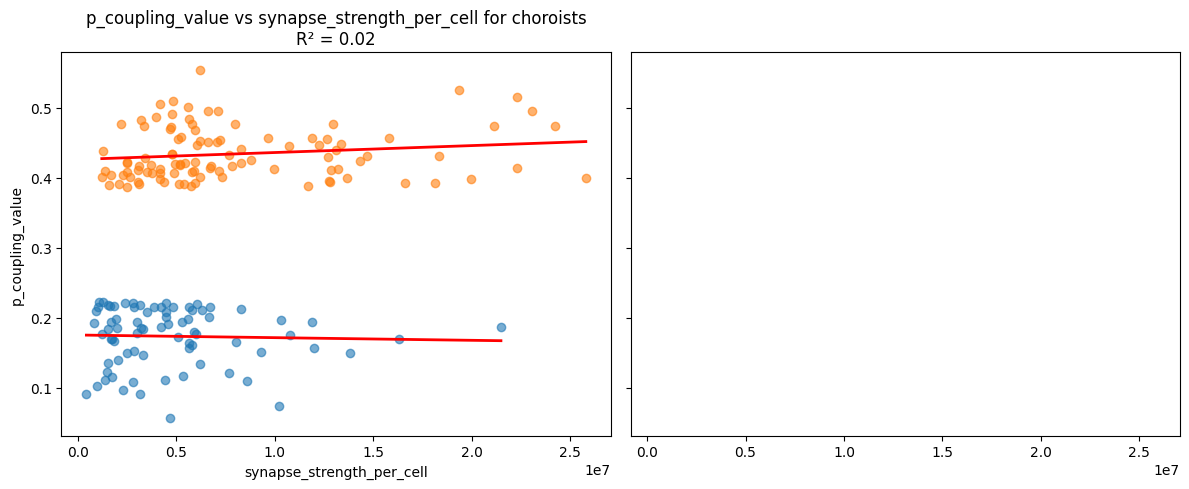

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

# Soloists plot
y_soloist = df_stimulus_soloist['p_coupling_value'].values
X_soloist = df_stimulus_soloist[x_variable].values

ax1.scatter(X_soloist, y_soloist, alpha=0.6)

# Linear regression for soloists
lr_soloist = LinearRegression()
lr_soloist.fit(X_soloist.reshape(-1, 1), y_soloist)
y_pred_soloist = lr_soloist.predict(X_soloist.reshape(-1, 1))
r2_soloist = r2_score(y_soloist, y_pred_soloist)
coef_soloist = lr_soloist.coef_[0]

# Plot regression line
x_range = np.linspace(np.nanmin(X_soloist), np.nanmax(X_soloist), 100)
y_range = lr_soloist.predict(x_range.reshape(-1, 1))
ax1.plot(x_range, y_range, 'r-', linewidth=2)

print(f"Soloists - R²: {r2_soloist:.4f}, Coefficient: {coef_soloist:.6f}")

ax1.set_xlabel(x_variable)
ax1.set_ylabel('p_coupling_value')
ax1.set_title(
    f'p_coupling_value vs {x_variable} for soloists\nR² = {r2_soloist:.2f}')
#ax1.set_xlim(0, 300)

# Choroists plot
y_choroist = df_stimulus_choroist['p_coupling_value'].values
X_choroist = df_stimulus_choroist[x_variable].values

ax1.scatter(X_choroist, y_choroist, alpha=0.6)

# Linear regression for choroists
lr_choroist = LinearRegression()
lr_choroist.fit(X_choroist.reshape(-1, 1), y_choroist)
y_pred_choroist = lr_choroist.predict(X_choroist.reshape(-1, 1))
r2_choroist = r2_score(y_choroist, y_pred_choroist)
coef_choroist = lr_choroist.coef_[0]

# Plot regression line
x_range = np.linspace(np.nanmin(X_choroist), np.nanmax(X_choroist), 100)
y_range = lr_choroist.predict(x_range.reshape(-1, 1))
ax1.plot(x_range, y_range, 'r-', linewidth=2)

print(f"Choroists - R²: {r2_choroist:.4f}, Coefficient: {coef_choroist:.6f}")

ax1.set_xlabel(x_variable)
ax1.set_ylabel('p_coupling_value')
ax1.set_title(
    f'p_coupling_value vs {x_variable} for choroists\nR² = {r2_choroist:.2f}')
#ax2.set_xlim(0, 300)

plt.tight_layout()

In [204]:
# Create probability distribution
values = inputs_per_cell.values[inputs_per_cell.values < 100]
counts, bins = np.histogram(values, bins=100)
probabilities = counts / counts.sum()

plt.bar(bins[:-1], probabilities, width=np.diff(bins), alpha=0.7)
plt.xlabel('Number of Common Inputs')
plt.ylabel('Probability')
plt.title('Probability Distribution of Common Inputs (< 10)')
#plt.ylim(0., 1.)
#plt.yscale('log')
plt.show()

NameError: name 'inputs_per_cell' is not defined

In [ ]:
inputs_per_cell_coregistered = dendrite_proofread_syn_coregistered_df.groupby(
    'post_pt_root_id').size()
print("Number of inputs per cell:")
print(inputs_per_cell_coregistered.head())
print(f"\nTotal cells receiving inputs: {len(inputs_per_cell_coregistered)}")
print(f"Average inputs per cell: {inputs_per_cell_coregistered.mean():.2f}")

Number of inputs per cell:
post_pt_root_id
8.646911e+17     900
8.646911e+17    1091
8.646911e+17      84
8.646911e+17      18
8.646911e+17    2887
dtype: int64

Total cells receiving inputs: 517
Average inputs per cell: 1688.57


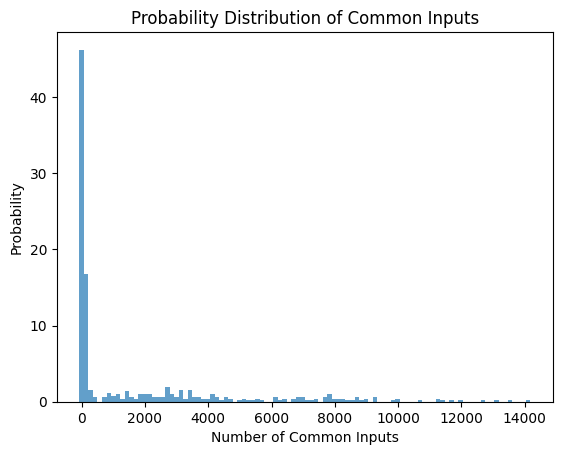

In [ ]:
# Create probability distribution
values = inputs_per_cell_coregistered.values
counts, bins = np.histogram(values, bins=100)
probabilities = counts / counts.sum() * 100

plt.bar(bins[:-1], probabilities, width=np.diff(bins), alpha=0.7)
plt.xlabel('Number of Common Inputs')
plt.ylabel('Probability')
plt.title('Probability Distribution of Common Inputs')
#plt.ylim(0., 1.)
#plt.yscale('log')
plt.show()

In [ ]:
inputs_per_cell_coregistered.shape

post_pt_root_id
8.646911e+17     900
8.646911e+17    1091
8.646911e+17      84
8.646911e+17      18
8.646911e+17    2887
                ... 
8.646911e+17      48
8.646911e+17      36
8.646911e+17     332
8.646911e+17      59
8.646911e+17      41
Length: 517, dtype: int64

In [41]:
pd.DataFrame(inputs_per_cell_coregistered)

,0
post_pt_root_id,
8.646911e+17,900
8.646911e+17,1091
8.646911e+17,84
8.646911e+17,18
8.646911e+17,2887
...,...
8.646911e+17,48
8.646911e+17,36
8.646911e+17,332


In [42]:
inputs_per_cell_coregistered = dendrite_proofread_syn_coregistered_df.groupby(
    'post_pt_root_id').size().reset_index(name='inputs_per_cell')

In [43]:
inputs_per_cell_coregistered

,post_pt_root_id,inputs_per_cell
0,8.646911e+17,900
1,8.646911e+17,1091
2,8.646911e+17,84
3,8.646911e+17,18
4,8.646911e+17,2887
...,...,...
512,8.646911e+17,48
513,8.646911e+17,36
514,8.646911e+17,332
515,8.646911e+17,59


In [46]:
coregisterd_with_coupling

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,pt_root_id,volume_x,cell_type_coarse,cell_type,column,volume_y,plane,roi,cell_role,p_coupling
0,279077,884.485,551.581,326.745,5.289889,234.119346,61.771196,864691132830842994,368.973950,E,L3-IT,1,3,0,143,choroist,-0.501840
1,276433,740.071,612.419,204.750,-142.011852,261.053111,-70.219681,864691132741466457,321.666672,E,L3-IT,1,3,2,40,soloist,1.802857
2,352939,927.553,616.377,287.280,42.142603,286.280855,9.472949,864691132770893729,275.509430,E,L3-IT,1,3,3,98,choroist,0.927976
3,352939,927.553,616.377,287.280,42.142603,286.280855,9.472949,864691132770893729,275.509430,E,L3-IT,1,3,3,98,choroist,0.394634
4,354027,897.832,551.658,344.025,18.165122,238.797609,78.834508,864691132999240117,245.712828,E,L3-IT,1,3,0,100,soloist,-1.375925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,353337,916.922,592.398,308.745,33.793975,268.797310,35.852350,864691132744008540,320.096619,E,L3-IT,1,3,2,236,choroist,-0.431024
567,366608,964.956,650.366,168.615,79.521924,287.086386,-113.906192,864691132810202401,324.457758,E,L3-IT,1,3,2,383,choroist,-0.250100
568,290884,848.944,658.203,114.615,-35.600955,280.693957,-168.343163,864691132925592361,281.775553,E,L4-IT,1,3,2,393,soloist,1.616635
569,277458,799.668,584.561,247.725,-80.593107,245.269306,-22.295072,864691132884727983,324.333108,E,L3-IT,1,3,0,89,choroist,-0.606978


In [ ]:
inputs_per_cell_coregistered = dendrite_proofread_syn_coregistered_df.groupby(
    'post_pt_root_id').size().reset_index(name='inputs_per_cell')

coregisterd_with_coupling_and_inputs_per_cell = coregisterd_with_coupling.merge(
    inputs_per_cell_coregistered,
    left_on='pt_root_id',
    right_on='post_pt_root_id',
    how='left')

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepare data for logistic regression
X = coregisterd_with_coupling_and_inputs_per_cell[
    'inputs_per_cell'].values.reshape(-1, 1)
y = (coregisterd_with_coupling_and_inputs_per_cell['p_coupling']
     > 0).astype(int)  # Convert to binary

# Remove any NaN values
mask = ~(np.isnan(X.flatten()) | np.isnan(y))
X = X[mask]
y = y[mask]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression
log_reg = LogisticRegression()
log_reg.fit(X_scaled, y)

print(f"Coefficient: {log_reg.coef_[0][0]:.4f}")
print(f"Intercept: {log_reg.intercept_[0]:.4f}")
print(f"Score: {log_reg.score(X_scaled, y):.4f}")

Coefficient: -0.1311
Intercept: 0.1090
Score: 0.5403


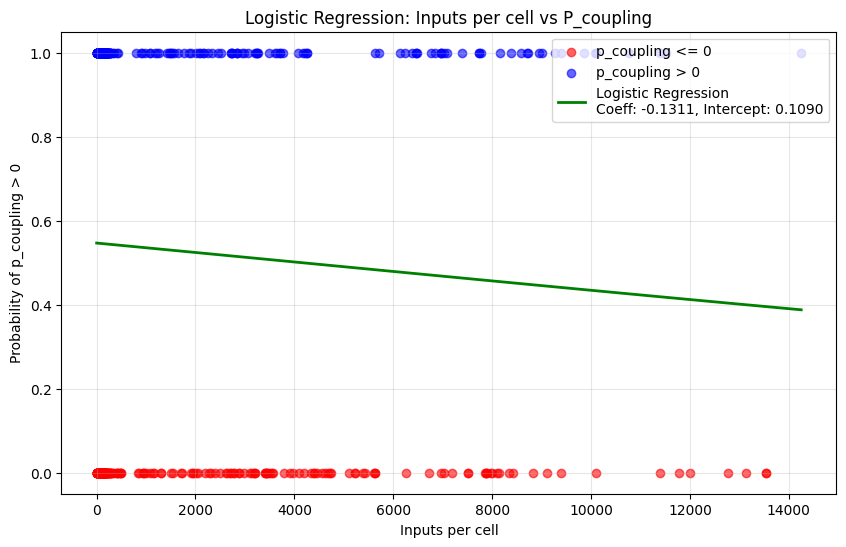

Number of valid data points: 533


In [ ]:
import matplotlib.pyplot as plt

# Create a range of x values for plotting the logistic curve
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
x_range_scaled = scaler.transform(x_range)

# Predict probabilities for the range
y_prob = log_reg.predict_proba(x_range_scaled)[:, 1]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the data points
plt.scatter(X[y == 0],
            y[y == 0],
            alpha=0.6,
            label='p_coupling <= 0',
            color='red')
plt.scatter(X[y == 1],
            y[y == 1],
            alpha=0.6,
            label='p_coupling > 0',
            color='blue')

# Plot the logistic regression curve
plt.plot(
    x_range,
    y_prob,
    'g-',
    linewidth=2,
    label=
    f'Logistic Regression\nCoeff: {log_reg.coef_[0][0]:.4f}, Intercept: {log_reg.intercept_[0]:.4f}'
)

plt.xlabel('Inputs per cell')
plt.ylabel('Probability of p_coupling > 0')
plt.title('Logistic Regression: Inputs per cell vs P_coupling')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Number of valid data points: {mask.sum()}")